In [1]:
import pandas as pd
import numpy as np
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('../datasets/train.txt', sep='\t', header=None, names=['Title', 'Origin', 'Genre', 'Director', 'Plot'])
print(data.head())

                       Title     Origin    Genre       Director  \
0               Ela Cheppanu     Telugu  romance         Ramana   
1  A Nightmare on Elm Street   American   horror   Samuel Bayer   
2            American Gothic   American   horror     John Hough   
3                       Gang  Bollywood    crime    Mazhar Khan   
4         Intimate Relations    British    drama  Charles Frank   

                                                Plot  
0  Sekhar (Tarun) is a graduate from IIM and work...  
1  Kris Fowles (Katie Cassidy) goes to the Spring...  
2  Cynthia is traumatized by the death of her bab...  
3  Four friends, Gangu (Jackie Shroff), Abdul (Na...  
4  Crisis in a middle-class family when the son f...  


In [3]:
stop_words = ["the", "to", "of", "a", 'and', 'is', 'his', 'in', 'he', 
            'that', 'her', "with", "by", "for", "him", "the", "as", "who",
            "on", "she", "but", "from", "has", "they", "an", "at", "their", "are",
            "into", "he", "out", "it", "up", "be", "was", "when", "not", "them", "which",
            "then", "after", "about", "where", "one", "have", "When", "After", "tells", "him.",
            "back", "She", "will", "while", "all", "two", "In", "had", "been", "They",
            "get", "only", "also", "before", "off", "being", "As", "goes", "takes",
            "this", "other", "take", "tries", "A", "her.", "go", "gets", "can", "man", "so",
            "over", "through", "down", "help", "new", "him,", "now", "comes", "next", "himself",
            "later", "however", "away", "there", "during", "both", "first", "again", "no", "way", "own",
            "some", "another", "more", "becomes", "make", "does", "what", "begins", "meanwhile", "just",
            "asks", "if", "because", "soon", "having", "its", "eventually", "come", "still", "between", "father",
            "house", "finds"
            ]

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.strip(' ')
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    text = ' '.join(filtered)
    return text

data['Clean_Plot'] = data['Plot'].apply(preprocess_text)
X = data['Clean_Plot'].values
y = data['Genre'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_133234/1324648065.py:28: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


## GloVe provides features

In [4]:
import numpy as np
glove_file = '../glove.6B/glove.6B.100d.txt'

# loads glove and embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embedding_vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = embedding_vector
    return embeddings_index


embeddings_index = load_glove_embeddings(glove_file)
print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 400000 word vectors.


In [5]:
def get_average_embedding(text, embeddings_index, embedding_dim=100):
    words = text.split()
    embedding_matrix = []
    
    for word in words:
        if word in embeddings_index:  # Check if the word has a GloVe embedding
            embedding_matrix.append(embeddings_index[word])
        else:
            embedding_matrix.append(np.zeros(embedding_dim))  # Use a zero vector for unknown words
    
    if len(embedding_matrix) > 0:
        # Average the embeddings to get a single vector for the plot
        return np.mean(embedding_matrix, axis=0)
    else:
        return np.zeros(embedding_dim)  # Return a zero vector if no embeddings were found


embedding_dim = 100  # Adjust this based on the GloVe file used
X_embeddings = np.array([get_average_embedding(plot, embeddings_index, embedding_dim) for plot in X])

# Logistic Regression with GloVe as feature provider

Accuracy: 0.6134244872591672
Classification Report:
               precision    recall  f1-score   support

      action       0.58      0.49      0.53       202
   animation       0.73      0.81      0.77       115
      comedy       0.57      0.53      0.55       223
       crime       0.49      0.69      0.57       108
       drama       0.57      0.40      0.47       319
      horror       0.78      0.72      0.75       223
     romance       0.52      0.62      0.57       186
      sci-fi       0.35      0.72      0.47        39
     western       0.78      0.88      0.83       194

    accuracy                           0.61      1609
   macro avg       0.60      0.65      0.61      1609
weighted avg       0.62      0.61      0.61      1609



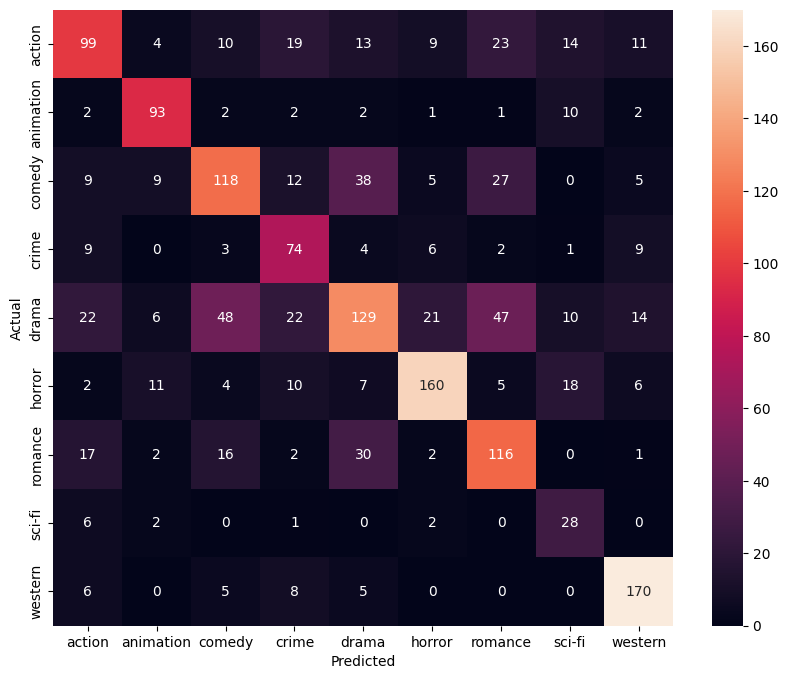

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

lr_model_glove = LogisticRegression(max_iter=1000, class_weight='balanced')

lr_model_glove.fit(X_train, y_train)
y_pred_glove = lr_model_glove.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_glove))
print("Classification Report:\n", classification_report(y_test, y_pred_glove, target_names=label_encoder.classes_))
# draws confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_glove)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## Logistic Regression with Tf-idf as feature provider

### General tf-idf

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['Clean_Plot'], data['Genre'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(min_df=20, stop_words=stop_words, ngram_range=(1, 3))

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Class based tf-idf

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['Clean_Plot'], data['Genre'], test_size=0.2, random_state=42)

def class_based_tfidf(X_train, y_train):
    tfidf_by_class = {}
    for genre in y_train.unique():
        # Get all plots for the current genre
        class_specific_plots = X_train[y_train == genre]
        # Create a TF-IDF Vectorizer and fit it on the specific genre
        vectorizer = TfidfVectorizer(min_df=20, stop_words=stop_words, ngram_range=(1, 3))
        tfidf_matrix = vectorizer.fit_transform(class_specific_plots)
        tfidf_by_class[genre] = (vectorizer, tfidf_matrix)
    return tfidf_by_class

class_tfidf = class_based_tfidf(X_train, y_train)

In [ ]:
def combine_tfidf(class_tfidf, X_data):
    # Dynamically calculate the total number of features
    total_feature_size = sum(vectorizer.get_feature_names_out().shape[0] for vectorizer, _ in class_tfidf.values())
    
    # Create a matrix to hold combined features
    combined_features = np.zeros((len(X_data), total_feature_size))  
    
    # Combine genre-specific TF-IDF vectors into a single feature vector for each document
    for i, plot in enumerate(X_data):
        feature_vector = []
        for genre, (vectorizer, _) in class_tfidf.items():
            # Transform the current plot using the TF-IDF vectorizer for this genre
            genre_tfidf = vectorizer.transform([plot]).toarray()
            feature_vector.extend(genre_tfidf.flatten())  # Flatten and add the genre-specific vector
        
        # Assign the combined feature vector to the corresponding row in the matrix
        combined_features[i, :len(feature_vector)] = np.array(feature_vector)
        
    return combined_features

X_train_tfidf = combine_tfidf(class_tfidf, X_train)
X_test_tfidf = combine_tfidf(class_tfidf, X_test)

In [9]:
lr_model = LogisticRegression(class_weight='balanced', solver='newton-cholesky')

lr_model.fit(X_train_tfidf, y_train)
y_pred = lr_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
conf_matrix = confusion_matrix(y_test, y_pred_glove)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()